In [15]:
import pyodbc
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
from wordcloud import WordCloud


sns.set(style="darkgrid")
plt.rcParams["figure.figsize"] = (20,8)

In [3]:
from helpers import TimeConverter, TimeDelta, TableCreator, GroupBarPlot, CatPlotter, columnsDict



In [ ]:
conn = pyodbc.connect(
    'Driver={ODBC Driver 17 for SQL Server};'
    'Server=35.204.21.80,1433;'
    'Database=master;'
    'uid=sa;pwd=Password123')



dataDict = TableCreator(conn)

### Data preparation

In this section we prepare the data for the visualisations below

In [5]:
# Data Preparation

#converts time feature to datetime
for table in dataDict:
    
    dataDict[table][columnsDict[table]['time']] = TimeConverter(dataDict[table][columnsDict[table]['time']])





#compute timedelta of onset of condition in years
dataDict['condition']['clinicalStatusDuration'] = TimeDelta(start=dataDict['condition']['onsetDateTime'],
                                                           end=datetime.datetime.now(),factor='Y')




#converts time feature to datetime
dataDict['encounter']['period_end'] = TimeConverter(dataDict['encounter']['period_end'])
dataDict['[procedure]']['performedPeriod_end'] = TimeConverter(dataDict['[procedure]']['performedPeriod_end'])


#compute timedelta of encounter (end-start) in hours
dataDict['encounter']['encounterDuration'] = TimeDelta(end=dataDict['encounter']['period_end'],
                                              start=dataDict['encounter']['period_start'],factor='H')



# converts to float value of observation
dataDict['observation']['value']=dataDict['observation']['value'].astype('float')



#extract year from time feature
dataDict['observation']['year']=dataDict['observation']['effectiveDateTime'].dt.year



#extract year/month from time feature
dataDict['[procedure]']['year']=dataDict['[procedure]']['performedPeriod_end'].dt.year
dataDict['[procedure]']['month']=dataDict['[procedure]']['performedPeriod_end'].dt.month




    

### Condition table

We can observe how active clinical status is more dispersed over time and intuitively has a longer time span than resolved

(<seaborn.axisgrid.FacetGrid at 0x1a1c81b2b0>, None, None)

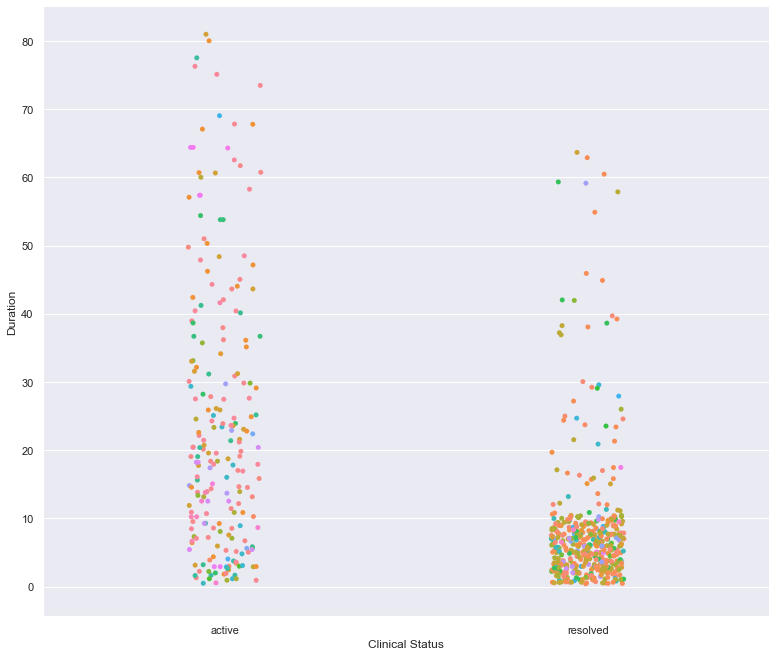

In [6]:
fig=sns.catplot(x="clinicalStatus", y="clinicalStatusDuration", hue="code", data=dataDict['condition'], legend=False)
(fig.set_axis_labels("Clinical Status", "Duration"),fig.fig.set_figwidth(12),
    fig.fig.set_figheight(10))




### Encounter tables

The distribution of the different classes of encounter over their duration in hours often presents outliers or some bimodality

[None, None, None, None, None]

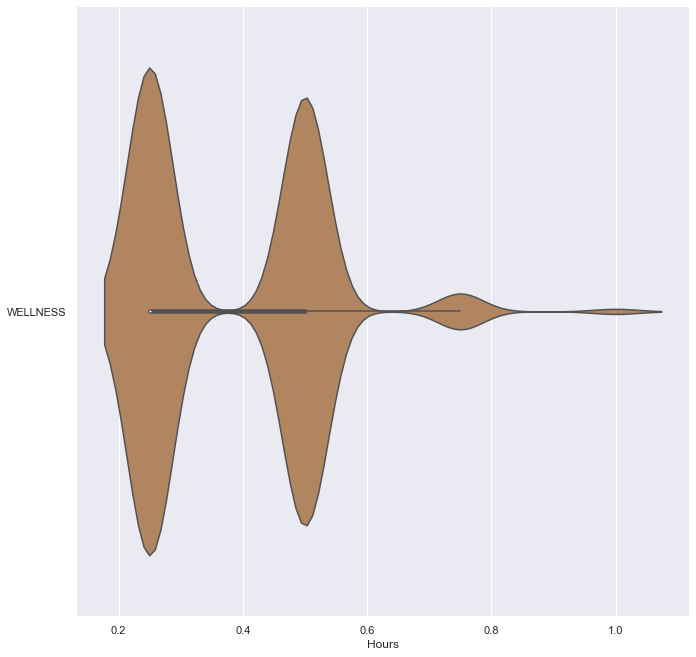

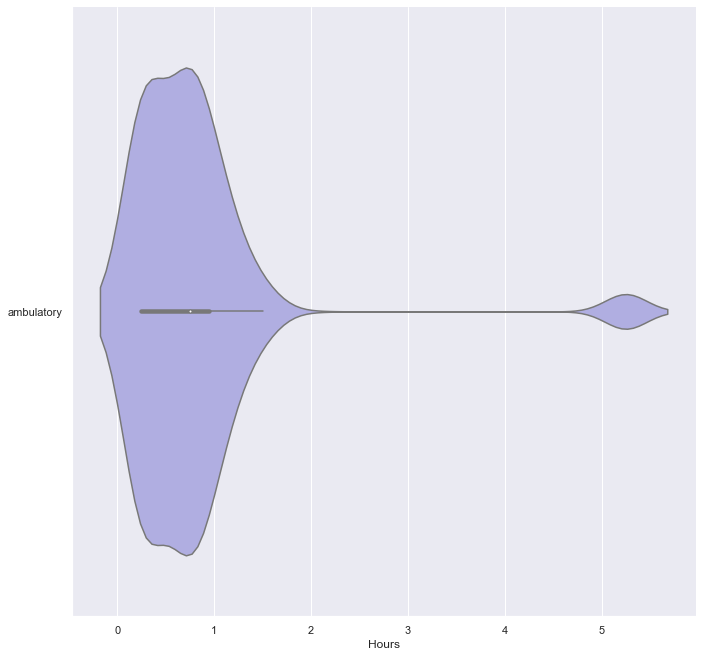

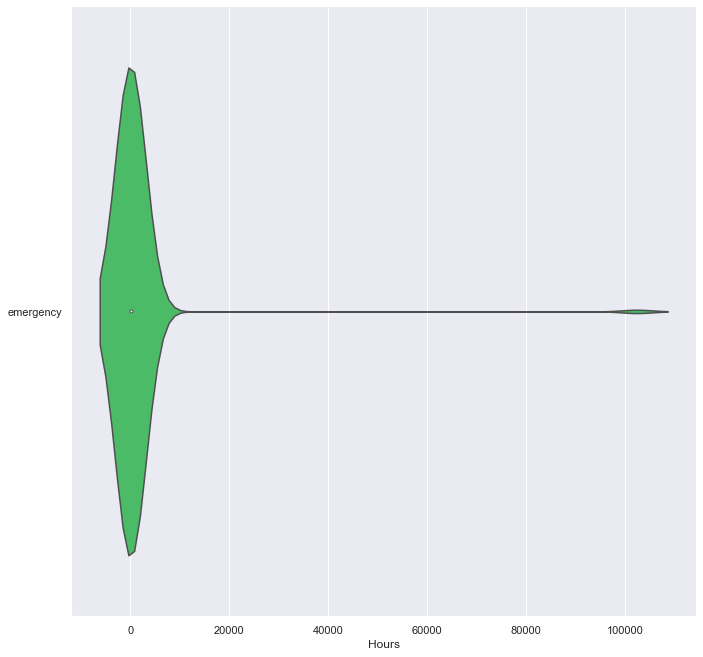

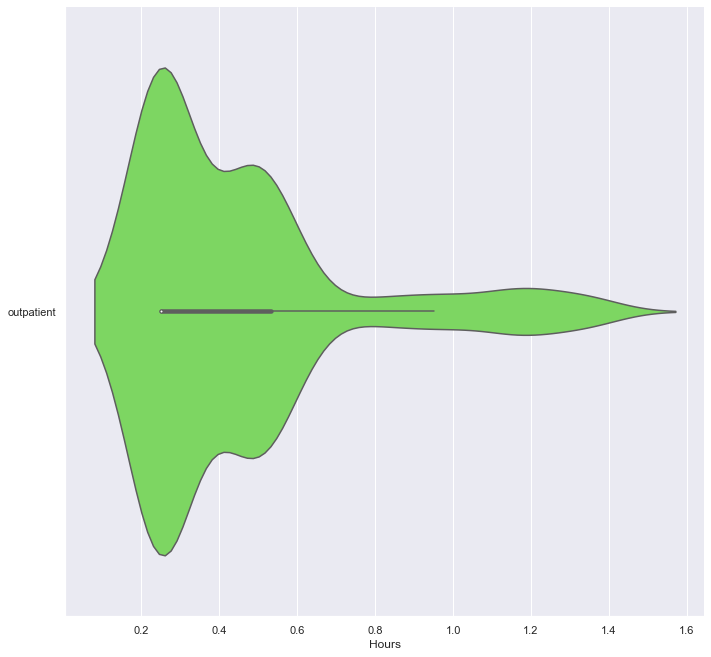

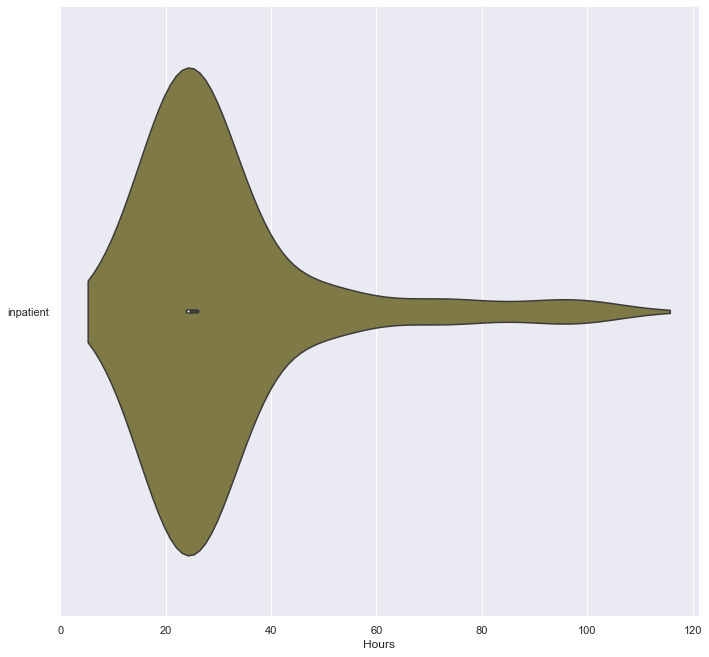

In [7]:
[CatPlotter(y='class', x="encounterDuration", val=val, table=dataDict['encounter']) for val in dataDict['encounter']['class'].unique()]



### Observation tables

Fun fact: average patient weight seem to correlate positively with economic cycles. (Correlation is not causation)

In [8]:
print(dataDict['observation']['code'].value_counts()[:5])



Body Weight                                 1058
Blood Pressure                              1058
Body Height                                 1058
Body Mass Index                              877
Hemoglobin A1c/Hemoglobin.total in Blood     566
Name: code, dtype: int64


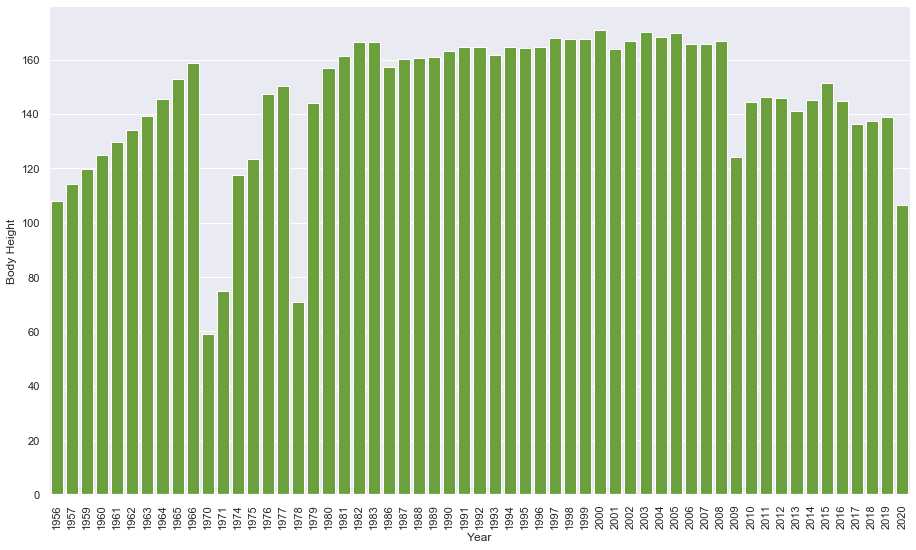

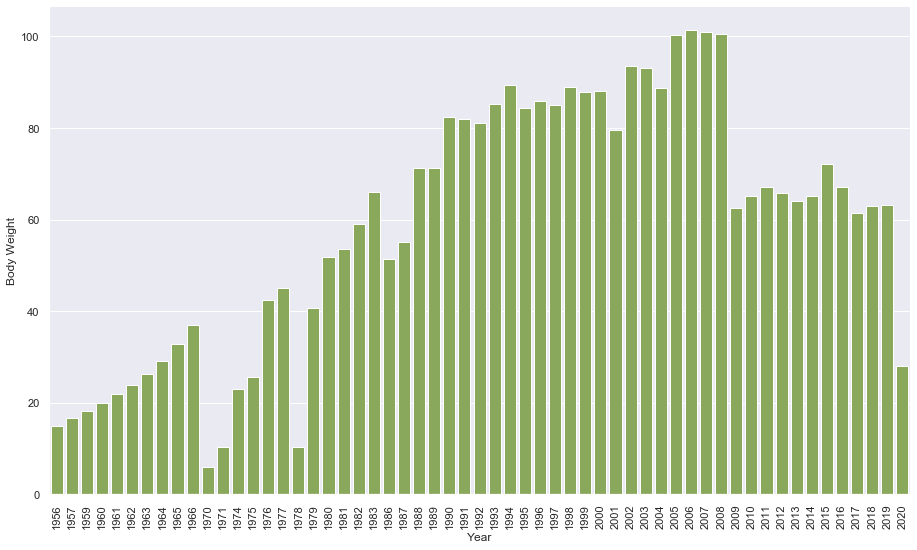

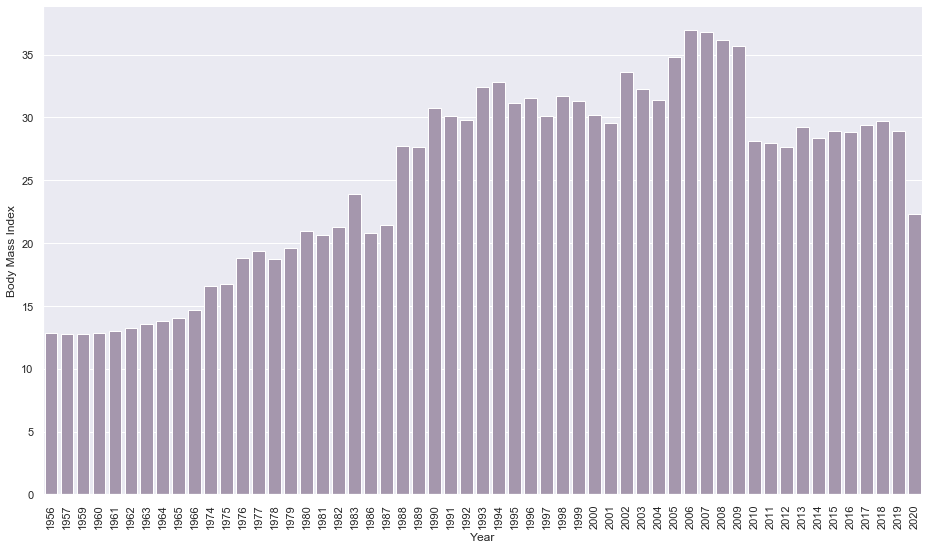

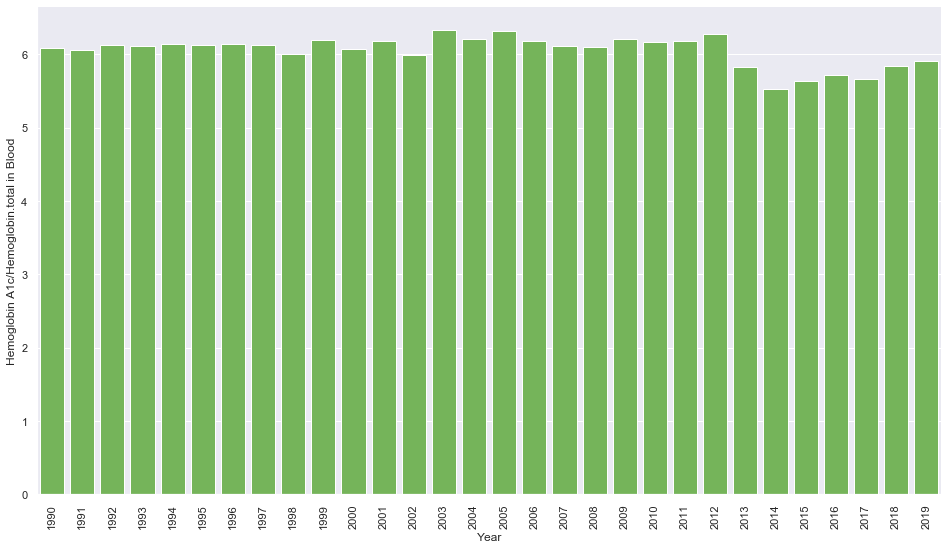

In [9]:
for val in ['Body Height','Body Weight','Body Mass Index', 'Hemoglobin A1c/Hemoglobin.total in Blood']:

    GroupBarPlot(dataDict['observation'],x='year',y='value',index='code',val=val)



### Medication request table

Oral medications seem to be more prevalent

In [ ]:
wordcloud = WordCloud(width = 1000, height = 1000, 
            background_color ='white', 
            min_font_size = 10).generate(' '.join(dataDict['medicationrequest']['medicationCodeableConcept'])) 



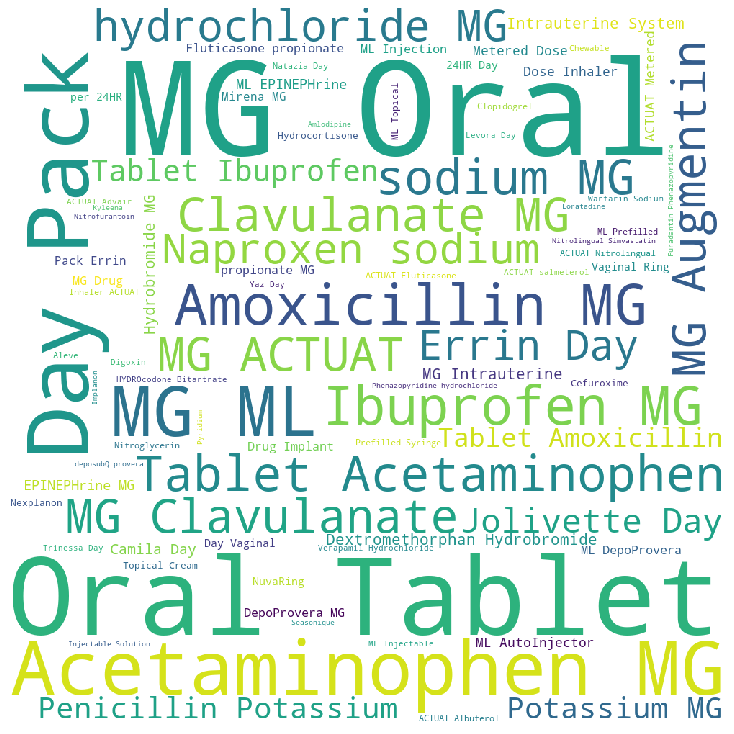

In [11]:
plt.figure(figsize = (10, 10), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 

plt.show() 

### Procedure table

The frequency of procedures does not seem to follow any particular within-year pattern

In [12]:
groupedProcedureDf = dataDict['[procedure]'][['reasonReference_display','year','month']].groupby(['year','month'], as_index=False).count()
groupedProcedureDf = groupedProcedureDf.pivot("month", "year", "reasonReference_display")



(Text(0.5, 48.5, 'Year'),
 Text(156.5, 0.5, 'Month'),
 Text(0.5, 1, 'Frequency of procedures'))

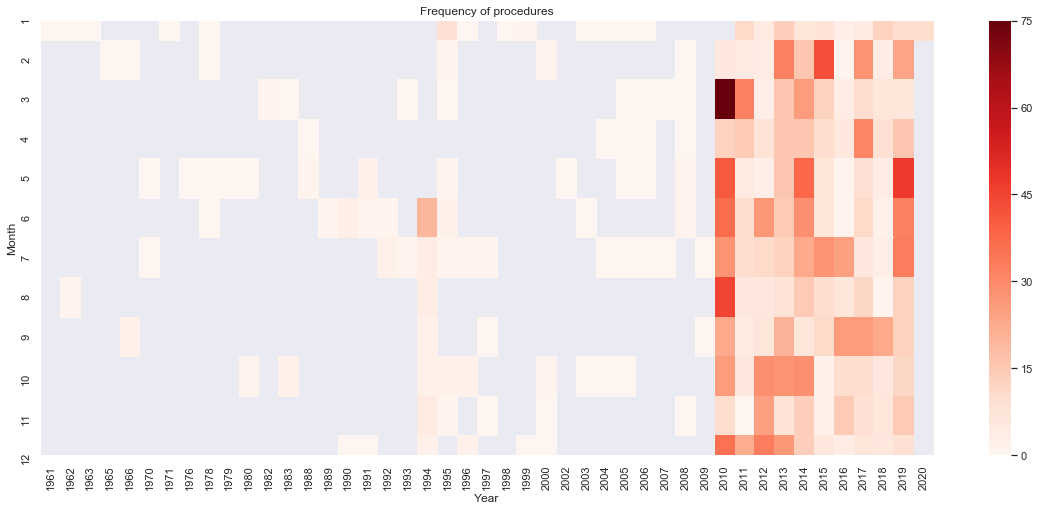

In [16]:

ax = sns.heatmap(groupedProcedureDf,cmap='Reds')
(ax.set_xlabel("Year"),ax.set_ylabel("Month"),
 ax.set_title('Frequency of procedures'))  


